# Import Libraries and Methods

In [1]:
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder as SafeImageFolder
import os
import warnings
from PIL import Image, UnidentifiedImageError
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from PIL import UnidentifiedImageError
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
import time
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as n




# Handle Corrupted Images with SafeImageFolder

In [14]:
class SafeImageFolder(ImageFolder):
    """
    A robust extension of torchvision.datasets.ImageFolder that skips corrupted or unreadable images
    instead of crashing. It attempts to load the image at the given index, and if an error occurs,
    it recursively tries the next image in the dataset.
    """

    def __getitem__(self, index):
        try:
            # Try to load the image and its corresponding label using the parent method
            return super().__getitem__(index)
        except (UnidentifiedImageError, OSError, ValueError) as e:
            # If the image is broken, log a warning with the index and the error type
            #warnings.warn(f"Skipping broken image at index {index}: {e}")

            # Move to the next image (using modulo to wrap around at the end of the dataset)
            # This ensures the function won't crash due to an index out of range
            return self.__getitem__((index + 1) % len(self))


# Dataset Preparation and Environment Setup

In [15]:
# Transform images: resize to 224x224 (standard for most CNNs) and convert to tensors
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224 pixels
    transforms.ToTensor(),          # Convert PIL image to PyTorch tensor (with values between 0 and 1)
])

# Load dataset using SafeImageFolder (handles corrupted images)
# Assumes each subfolder in 'Incidents-subset' corresponds to a class
dataset = SafeImageFolder(root='Incidents-subset', transform=transform)

# Extract class names and count
class_names = dataset.classes
num_classes = len(class_names)


# Set device to GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Visualize Dataset

Total images: 7308


/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training dataset size with KFold=5: 5846
Test dataset size with KFold=5: 1462

Number of classes in the dataset: 12
Classes in the dataset:  ['airplane accident', 'bicycle accident', 'car accident', 'collapsed', 'earthquake', 'flooded', 'ice storm', 'nuclear explosion', 'oil spill', 'tornado', 'volcanic eruption', 'wildfire']
Index of each class:  {'airplane accident': 0, 'bicycle accident': 1, 'car accident': 2, 'collapsed': 3, 'earthquake': 4, 'flooded': 5, 'ice storm': 6, 'nuclear explosion': 7, 'oil spill': 8, 'tornado': 9, 'volcanic eruption': 10, 'wildfire': 11}

Number of images for each label:
Label 0: 874 images
Label 1: 228 images
Label 2: 966 images
Label 3: 631 images
Label 4: 925 images
Label 5: 958 images
Label 6: 615 images
Label 7: 231 images
Label 8: 294 images
Label 9: 281 images
Label 10: 628 images
Label 11: 677 images


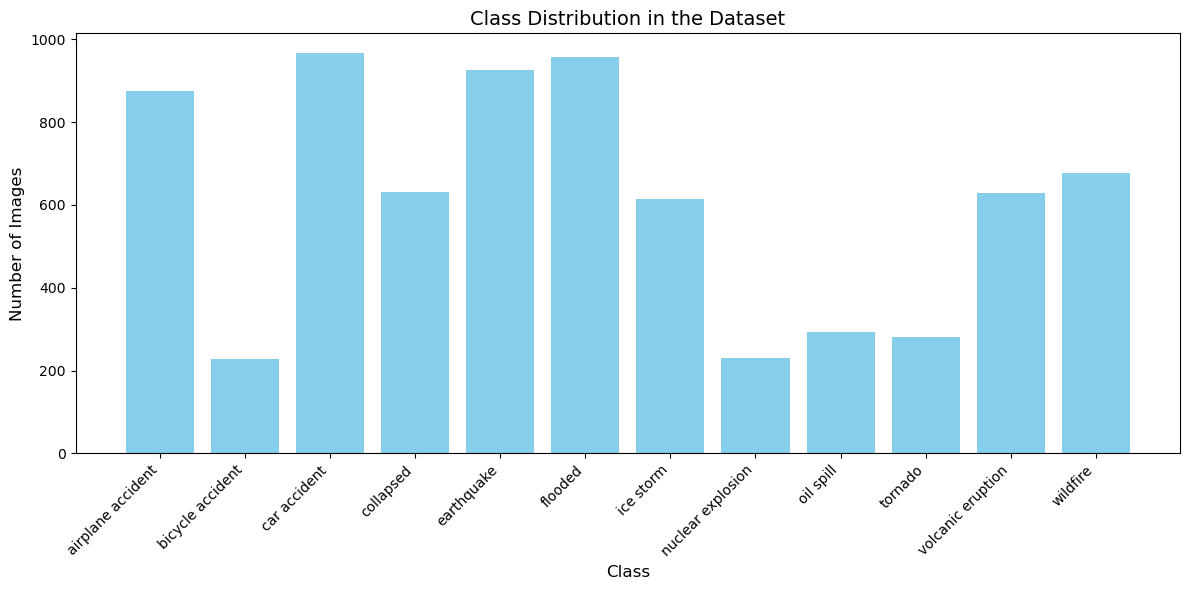


First image in the dataset:
Image shape: torch.Size([3, 224, 224])
Label: 0
Label name: airplane accident


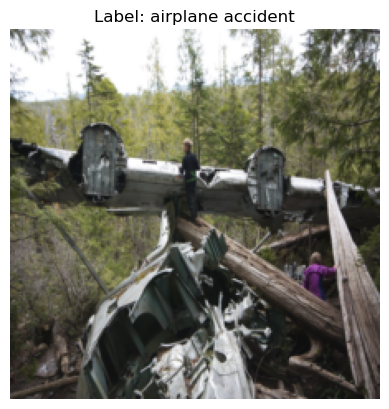

In [17]:
# print the number of images in the training and test sets
print(f"Total images: {len(dataset)}")

# Simulate 1 fold to show train/test sizes for KFold=5
y_all = np.array([label for _, label in dataset])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in skf.split(np.zeros(len(y_all)), y_all):
    print(f"Training dataset size with KFold=5: {len(train_idx)}")
    print(f"Test dataset size with KFold=5: {len(test_idx)}\n")
    break

# print the classes in the dataset
print(f"Number of classes in the dataset: {len(dataset.classes)}")
print(f"Classes in the dataset:  {dataset.classes}")
print(f"Index of each class:  {dataset.class_to_idx}\n")

# Count the number of images for each label in dataset
counter = Counter(dataset.targets)
print("Number of images for each label:")
for label, count in counter.items():
    print(f"Label {label}: {count} images")

# Visualize the class distribution using a bar chart
labels = [dataset.classes[i] for i in counter.keys()]
counts = list(counter.values())

plt.figure(figsize=(12, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Class Distribution in the Dataset', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

# Print the shape of an first image in the dataset add also the label
print("\nFirst image in the dataset:")
image, label = dataset[0]
print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Label name: {dataset.classes[label]}")

# Display the image
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {dataset.classes[label]}")
plt.axis('off')
plt.show()





In [ ]:
# Show one example image per class in the dataset

# Collect the first encountered image for each class
example_images = {}
for image, label in dataset:
    class_name = dataset.classes[label]
    if class_name not in example_images:
        example_images[class_name] = image
    if len(example_images) == len(dataset.classes):
        break  # Stop once we have one image per class

# Set grid layout for plotting
num_classes = len(example_images)
cols = 4
rows = (num_classes + cols - 1) // cols  # Calculate required rows

plt.figure(figsize=(cols * 4, rows * 4))

# Plot each image with its class name
for i, (class_name, image) in enumerate(sorted(example_images.items())):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(image.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("One Example Image per Class", fontsize=18, y=1.03)
plt.show()



/usr/lib/python3/dist-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# Evaluation Function

In [6]:
def evaluate_model(y_true, y_pred, class_names=None, model_name="Model"):
    print(f"\nEvaluation Results for {model_name}")
    
    # Compute key metrics
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    # Print metrics
    print(f"Accuracy:                {acc:.4f}")
    print(f"Balanced Accuracy:       {bal_acc:.4f}")
    print(f"Precision (macro):       {precision:.4f}")
    print(f"Recall (macro):          {recall:.4f}")
    print(f"F1 Score (macro):        {f1:.4f}")
    print(f"Matthews Corr. Coeff.:   {mcc:.4f}")
    
    # Classification report (per class)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    
    # Confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# BASELINE MODEL (RANDOM FOREST)

In [7]:
# Extracts a normalized color histogram from a tensor image (C, H, W)
def extract_color_histogram_from_tensor(img_tensor, bins=16):
    img_np = img_tensor.permute(1, 2, 0).numpy()  # Convert to (H, W, C) format
    hist_r, _ = np.histogram(img_np[:, :, 0], bins=bins, range=(0, 1), density=True)
    hist_g, _ = np.histogram(img_np[:, :, 1], bins=bins, range=(0, 1), density=True)
    hist_b, _ = np.histogram(img_np[:, :, 2], bins=bins, range=(0, 1), density=True)
    return np.concatenate([hist_r, hist_g, hist_b])


/tmp/ipykernel_857/2155748996.py:14: UserWarning: Skipping broken image at index 25: cannot identify image file <_io.BufferedReader name='Incidents-subset/airplane accident/.hashed.6f95947e.desktop.story.share.jpg'>
  warnings.warn(f"Skipping broken image at index {index}: {e}")
/tmp/ipykernel_857/2155748996.py:14: UserWarning: Skipping broken image at index 358: cannot identify image file <_io.BufferedReader name='Incidents-subset/airplane accident/AR-190939882.jpg'>
  warnings.warn(f"Skipping broken image at index {index}: {e}")
/tmp/ipykernel_857/2155748996.py:14: UserWarning: Skipping broken image at index 2728: cannot identify image file <_io.BufferedReader name='Incidents-subset/earthquake/.hashed.909e0e37.desktop.story.share.jpg'>
  warnings.warn(f"Skipping broken image at index {index}: {e}")
/tmp/ipykernel_857/2155748996.py:14: UserWarning: Skipping broken image at index 3656: cannot identify image file <_io.BufferedReader name='Incidents-subset/flooded/.53_format=1.7777777777

Running Stratified 5-Fold Cross-Validation with Random Forest (color histograms) 

Processing Fold 1
Time taken for Fold 1: 3.83 seconds

Processing Fold 2
Time taken for Fold 2: 3.74 seconds

Processing Fold 3
Time taken for Fold 3: 3.84 seconds

Processing Fold 4
Time taken for Fold 4: 3.83 seconds

Processing Fold 5
Time taken for Fold 5: 3.77 seconds

Total time for all folds: 19.00 seconds

Evaluation Results for Random Forest
Accuracy:                0.3618
Balanced Accuracy:       0.2873
Precision (macro):       0.3699
Recall (macro):          0.2873
F1 Score (macro):        0.2793
Matthews Corr. Coeff.:   0.2824

Classification Report:
                   precision    recall  f1-score   support

airplane accident       0.31      0.32      0.32       874
 bicycle accident       0.27      0.02      0.03       228
     car accident       0.35      0.55      0.43       966
        collapsed       0.22      0.10      0.13       631
       earthquake       0.32      0.46      0.38    

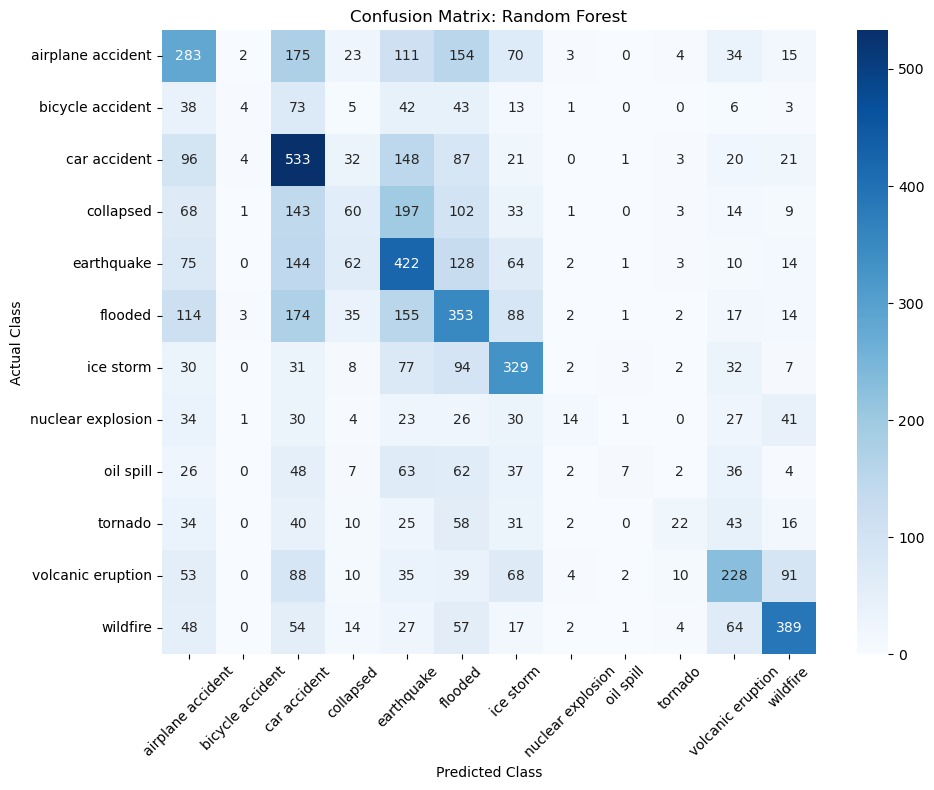

In [19]:
# Extract color histogram features and labels from the dataset
X_all, y_all = [], []
for img, label in dataset:
    feature = extract_color_histogram_from_tensor(img, bins=16)
    X_all.append(feature)
    y_all.append(label)

X_all = np.array(X_all)
y_all = np.array(y_all)

# Stratified 5-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_y_true = []
all_y_pred = []

print("Running Stratified 5-Fold Cross-Validation with Random Forest (color histograms) \n")

# Start total timer
total_start_time = time.time()

for fold, (train_idx, test_idx) in enumerate(skf.split(X_all, y_all)):
    print(f"Processing Fold {fold + 1}")
    fold_start_time = time.time()

    # Split features and labels for current fold
    X_train, X_test = X_all[train_idx], X_all[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    # Train a Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Predict on the test split
    y_pred = clf.predict(X_test)

    # Store predictions for evaluation
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

    # End fold timer
    fold_end_time = time.time()
    fold_duration = fold_end_time - fold_start_time
    print(f"Time taken for Fold {fold + 1}: {fold_duration:.2f} seconds\n")

# End total timer
total_end_time = time.time()
total_duration = total_end_time - total_start_time
print(f"Total time for all folds: {total_duration:.2f} seconds")

# Evaluate model performance across all folds
evaluate_model(all_y_true, all_y_pred, class_names=class_names, model_name="Random Forest")



# Functions for Deep Learning Models

In [8]:
def train_with_kfold(model_name, model_fn, adjust_classifier_fn, dataset, class_names, num_classes, device, batch_size=32, epochs=5):
    print(f"\nStarting Stratified 5-Fold Cross-Validation for {model_name}")

    # Extract all images and labels
    X_all = [img for img, label in dataset]
    y_all = [label for _, label in dataset]
    y_all = np.array(y_all)

    # Create Stratified K-Fold splitter
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    all_y_true = []
    all_y_pred = []

    total_start_time = time.time()

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_all, y_all)):
        fold_start_time = time.time()
        print(f"\nFold {fold + 1}")

        # Subset data for this fold
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        test_subset = torch.utils.data.Subset(dataset, test_idx)

        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

        # Load model and adjust classifier
        model = model_fn(pretrained=True)
        model = adjust_classifier_fn(model, num_classes)
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

        # Training
        model.train()
        for epoch in range(epochs):
            running_loss, correct, total = 0.0, 0, 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = correct / total
            print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")

        # Evaluation
        model.eval()
        y_true_fold, y_pred_fold = [], []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                y_true_fold.extend(labels.numpy())
                y_pred_fold.extend(preds.cpu().numpy())

        all_y_true.extend(y_true_fold)
        all_y_pred.extend(y_pred_fold)

        fold_end_time = time.time()
        print(f"Time taken for Fold {fold + 1}: {fold_end_time - fold_start_time:.2f} seconds")

    total_time = time.time() - total_start_time
    print(f"\nTotal time for all folds: {total_time:.2f} seconds")

    print(f"\nFinal Evaluation for {model_name} (5-Fold Average):")
    evaluate_model(all_y_true, all_y_pred, class_names=class_names, model_name=model_name)

In [9]:
# For ResNet18
def adjust_resnet(model, num_classes):
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# For EfficientNet-B0
def adjust_efficientnet(model, num_classes):
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

# For DenseNet121
def adjust_densenet(model, num_classes):
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model


# RESNET18 MODEL


Starting Stratified 5-Fold Cross-Validation for ResNet18


/tmp/ipykernel_1139/2155748996.py:14: UserWarning: Skipping broken image at index 25: cannot identify image file <_io.BufferedReader name='Incidents-subset/airplane accident/.hashed.6f95947e.desktop.story.share.jpg'>
  warnings.warn(f"Skipping broken image at index {index}: {e}")
/tmp/ipykernel_1139/2155748996.py:14: UserWarning: Skipping broken image at index 358: cannot identify image file <_io.BufferedReader name='Incidents-subset/airplane accident/AR-190939882.jpg'>
  warnings.warn(f"Skipping broken image at index {index}: {e}")
/tmp/ipykernel_1139/2155748996.py:14: UserWarning: Skipping broken image at index 2728: cannot identify image file <_io.BufferedReader name='Incidents-subset/earthquake/.hashed.909e0e37.desktop.story.share.jpg'>
  warnings.warn(f"Skipping broken image at index {index}: {e}")
/tmp/ipykernel_1139/2155748996.py:14: UserWarning: Skipping broken image at index 3656: cannot identify image file <_io.BufferedReader name='Incidents-subset/flooded/.53_format=1.777777


Fold 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_1139/2155748996.py:14: UserWarning: Skipping broken image at index 3656: cannot identify image file <_io.BufferedReader name='Incidents-subset/flooded/.53_format=1.7777777777777777__image.jpg'>
  warnings.warn(f"Skipping broken image at index {index}: {e}")
/tmp/ipykernel_1139/2155748996.py:14: UserWarning: Skipping broken image at index 25: cannot identify im

Epoch 1/5 - Loss: 1.3528 - Accuracy: 0.5953
Epoch 2/5 - Loss: 0.8067 - Accuracy: 0.7477
Epoch 3/5 - Loss: 0.6826 - Accuracy: 0.7829
Epoch 4/5 - Loss: 0.6374 - Accuracy: 0.7917
Epoch 5/5 - Loss: 0.5924 - Accuracy: 0.8069


/tmp/ipykernel_1139/2155748996.py:14: UserWarning: Skipping broken image at index 358: cannot identify image file <_io.BufferedReader name='Incidents-subset/airplane accident/AR-190939882.jpg'>
  warnings.warn(f"Skipping broken image at index {index}: {e}")


Time taken for Fold 1: 573.15 seconds

Fold 2
Epoch 1/5 - Loss: 1.3887 - Accuracy: 0.5768
Epoch 2/5 - Loss: 0.8028 - Accuracy: 0.7586
Epoch 3/5 - Loss: 0.6853 - Accuracy: 0.7886
Epoch 4/5 - Loss: 0.6309 - Accuracy: 0.7976
Epoch 5/5 - Loss: 0.5904 - Accuracy: 0.8127
Time taken for Fold 2: 579.86 seconds

Fold 3
Epoch 1/5 - Loss: 1.3588 - Accuracy: 0.5874
Epoch 2/5 - Loss: 0.8253 - Accuracy: 0.7402
Epoch 3/5 - Loss: 0.7023 - Accuracy: 0.7759
Epoch 4/5 - Loss: 0.6450 - Accuracy: 0.7934
Epoch 5/5 - Loss: 0.6138 - Accuracy: 0.8036
Time taken for Fold 3: 552.27 seconds

Fold 4
Epoch 1/5 - Loss: 1.3674 - Accuracy: 0.5847
Epoch 2/5 - Loss: 0.8171 - Accuracy: 0.7488
Epoch 3/5 - Loss: 0.7039 - Accuracy: 0.7772
Epoch 4/5 - Loss: 0.6431 - Accuracy: 0.7920
Epoch 5/5 - Loss: 0.6153 - Accuracy: 0.7972
Time taken for Fold 4: 561.56 seconds

Fold 5
Epoch 1/5 - Loss: 1.3858 - Accuracy: 0.5835
Epoch 2/5 - Loss: 0.8129 - Accuracy: 0.7558
Epoch 3/5 - Loss: 0.7009 - Accuracy: 0.7787
Epoch 4/5 - Loss: 0.6295

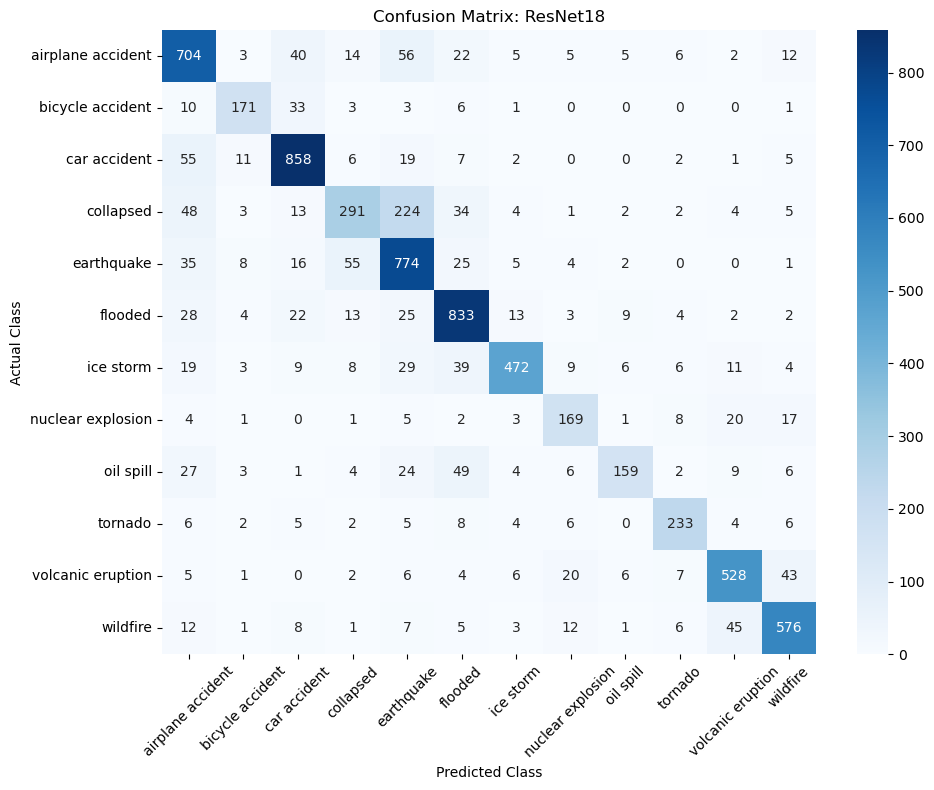

In [10]:
from torchvision import models

train_with_kfold(
    model_name="ResNet18",
    model_fn=models.resnet18,
    adjust_classifier_fn=adjust_resnet,
    dataset=dataset,
    class_names=class_names,
    num_classes=num_classes,
    device=device,
    batch_size=32,
    epochs=5
)


# EfficientNet B0 MODEL

In [ ]:
train_with_kfold(
    model_name="EfficientNet-B0",
    model_fn=models.efficientnet_b0,
    adjust_classifier_fn=adjust_efficientnet,
    dataset=dataset,
    class_names=class_names,
    num_classes=num_classes,
    device=device,
    batch_size=16,
    epochs=5
)


# DenseNet121 MODEL

/tmp/ipykernel_256/1419864693.py:6: UserWarning:  Skipping broken image at index 25: cannot identify image file <_io.BufferedReader name='Incidents-subset/airplane accident/.hashed.6f95947e.desktop.story.share.jpg'>
  warnings.warn(f" Skipping broken image at index {index}: {e}")
/tmp/ipykernel_256/1419864693.py:6: UserWarning:  Skipping broken image at index 358: cannot identify image file <_io.BufferedReader name='Incidents-subset/airplane accident/AR-190939882.jpg'>
  warnings.warn(f" Skipping broken image at index {index}: {e}")
/tmp/ipykernel_256/1419864693.py:6: UserWarning:  Skipping broken image at index 2728: cannot identify image file <_io.BufferedReader name='Incidents-subset/earthquake/.hashed.909e0e37.desktop.story.share.jpg'>
  warnings.warn(f" Skipping broken image at index {index}: {e}")
/tmp/ipykernel_256/1419864693.py:6: UserWarning:  Skipping broken image at index 3656: cannot identify image file <_io.BufferedReader name='Incidents-subset/flooded/.53_format=1.7777777

Starting Stratified 5-Fold Cross-Validation for DenseNet121...
Fold 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/jovyan/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 313MB/s]
/tmp/ipykernel_256/1419864693.py:6: UserWarning:  Skipping broken image at index 5435: cannot identify image file <_io.BufferedReader name='Incidents-subset/oil spill/.jpg'>

Epoch 1/5 - Loss: 1.2390 - Accuracy: 0.6213
Epoch 2/5 - Loss: 0.7460 - Accuracy: 0.7639
Epoch 3/5 - Loss: 0.6475 - Accuracy: 0.7923
Epoch 4/5 - Loss: 0.6005 - Accuracy: 0.7988
Epoch 5/5 - Loss: 0.5726 - Accuracy: 0.8122


/tmp/ipykernel_256/1419864693.py:6: UserWarning:  Skipping broken image at index 358: cannot identify image file <_io.BufferedReader name='Incidents-subset/airplane accident/AR-190939882.jpg'>
  warnings.warn(f" Skipping broken image at index {index}: {e}")


Fold 2
Epoch 1/5 - Loss: 1.2153 - Accuracy: 0.6372
Epoch 2/5 - Loss: 0.7221 - Accuracy: 0.7745
Epoch 3/5 - Loss: 0.6179 - Accuracy: 0.8057
Epoch 4/5 - Loss: 0.5797 - Accuracy: 0.8129
Epoch 5/5 - Loss: 0.5548 - Accuracy: 0.8185
Fold 3
Epoch 1/5 - Loss: 1.2239 - Accuracy: 0.6226
Epoch 2/5 - Loss: 0.7399 - Accuracy: 0.7720
Epoch 3/5 - Loss: 0.6438 - Accuracy: 0.7988
Epoch 4/5 - Loss: 0.5926 - Accuracy: 0.8093
Epoch 5/5 - Loss: 0.5616 - Accuracy: 0.8173
Fold 4
Epoch 1/5 - Loss: 1.2284 - Accuracy: 0.6241
Epoch 2/5 - Loss: 0.7452 - Accuracy: 0.7691
Epoch 3/5 - Loss: 0.6378 - Accuracy: 0.7973
Epoch 4/5 - Loss: 0.6118 - Accuracy: 0.8049
Epoch 5/5 - Loss: 0.5807 - Accuracy: 0.8059
Fold 5
Epoch 1/5 - Loss: 1.2208 - Accuracy: 0.6282
Epoch 2/5 - Loss: 0.7384 - Accuracy: 0.7700
Epoch 3/5 - Loss: 0.6491 - Accuracy: 0.7934
Epoch 4/5 - Loss: 0.6156 - Accuracy: 0.7970
Epoch 5/5 - Loss: 0.5759 - Accuracy: 0.8043

Final Evaluation for DenseNet121 (5-Fold Average):

Evaluation Results for DenseNet121:

Ac

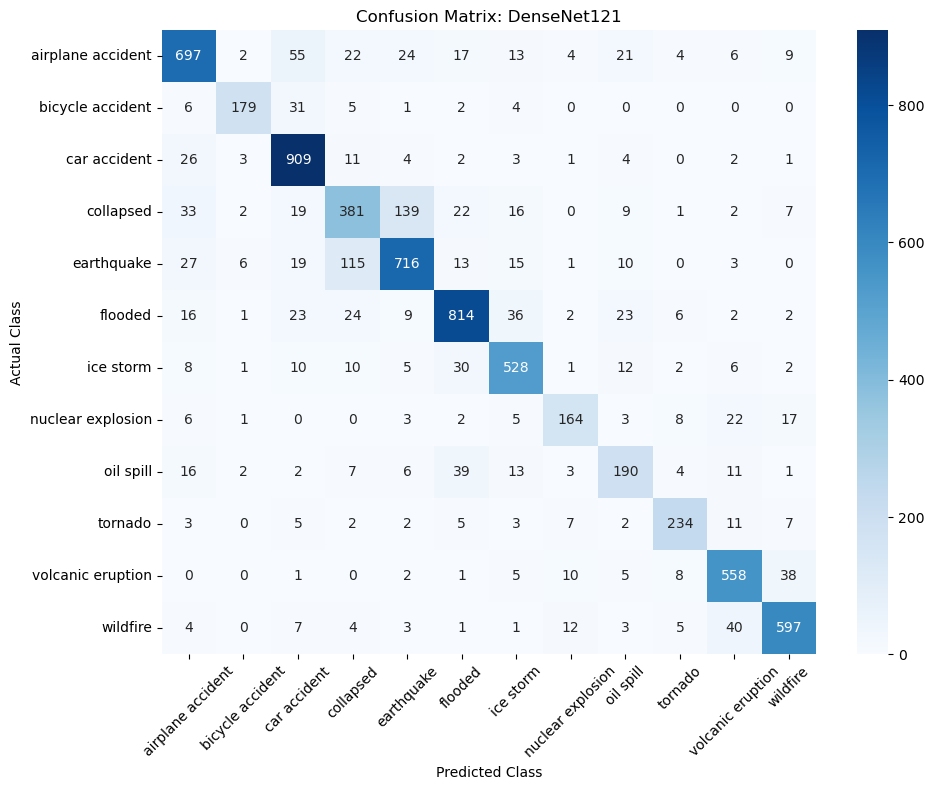

In [13]:
train_with_kfold(
    model_name="DenseNet121",
    model_fn=models.densenet121,
    adjust_classifier_fn=adjust_densenet,
    dataset=dataset,
    class_names=class_names,
    num_classes=num_classes,
    device=device,
    batch_size=16,
    epochs=5
)

# BASELINE MODE with OVERSAMPLING (RANDOM FOREST)

In [26]:
# === Feature extraction for Random Forest only ===
X_all, y_all = [], []
for img, label in dataset:
    feature = extract_color_histogram_from_tensor(img, bins=16)
    X_all.append(feature)
    y_all.append(label)

X_all = np.array(X_all)
y_all = np.array(y_all)

# === Oversampling ===
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_all, y_all)

print("Class distribution after oversampling:", np.bincount(y_resampled))


/tmp/ipykernel_271/1419864693.py:6: UserWarning:  Skipping broken image at index 25: cannot identify image file <_io.BufferedReader name='Incidents-subset/airplane accident/.hashed.6f95947e.desktop.story.share.jpg'>
  warnings.warn(f" Skipping broken image at index {index}: {e}")
/tmp/ipykernel_271/1419864693.py:6: UserWarning:  Skipping broken image at index 358: cannot identify image file <_io.BufferedReader name='Incidents-subset/airplane accident/AR-190939882.jpg'>
  warnings.warn(f" Skipping broken image at index {index}: {e}")
/tmp/ipykernel_271/1419864693.py:6: UserWarning:  Skipping broken image at index 2728: cannot identify image file <_io.BufferedReader name='Incidents-subset/earthquake/.hashed.909e0e37.desktop.story.share.jpg'>
  warnings.warn(f" Skipping broken image at index {index}: {e}")
/tmp/ipykernel_271/1419864693.py:6: UserWarning:  Skipping broken image at index 3656: cannot identify image file <_io.BufferedReader name='Incidents-subset/flooded/.53_format=1.7777777

Class distribution after oversampling: [966 966 966 966 966 966 966 966 966 966 966 966]


/tmp/ipykernel_271/1419864693.py:6: UserWarning:  Skipping broken image at index 7302: cannot identify image file <_io.BufferedReader name='Incidents-subset/wildfire/wildfires-g.jpg'>
  warnings.warn(f" Skipping broken image at index {index}: {e}")


Running Stratified 5-Fold Cross-Validation with Random Forest (OVERSAMPLED color histograms)...

Processing Fold 1
Processing Fold 2
Processing Fold 3
Processing Fold 4
Processing Fold 5

Evaluation Results for Random Forest (Oversampled) 
Accuracy:                0.6943
Balanced Accuracy:       0.6943
Precision (macro):       0.6907
Recall (macro):          0.6943
F1 Score (macro):        0.6906
Matthews Corr. Coeff.:   0.6669

Classification Report 
                   precision    recall  f1-score   support

airplane accident       0.49      0.41      0.45       966
 bicycle accident       0.92      0.97      0.94       966
     car accident       0.42      0.48      0.45       966
        collapsed       0.64      0.59      0.61       966
       earthquake       0.42      0.45      0.44       966
          flooded       0.38      0.32      0.35       966
        ice storm       0.67      0.81      0.73       966
nuclear explosion       0.91      0.98      0.94       966
        oil 

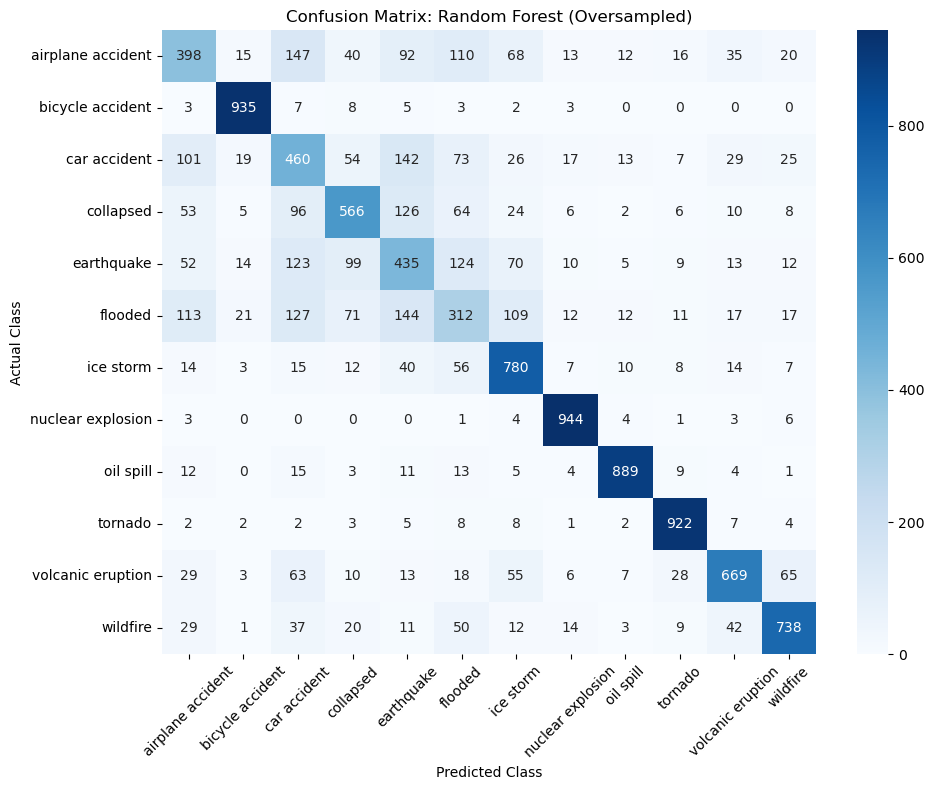

In [27]:
# === Random Forest with Stratified K-Fold ===
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_y_true = []
all_y_pred = []

print("Running Stratified 5-Fold Cross-Validation with Random Forest (OVERSAMPLED color histograms)...\n")

for fold, (train_idx, test_idx) in enumerate(skf.split(X_resampled, y_resampled)):
    print(f"Processing Fold {fold + 1}")
    X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
    y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

evaluate_model(all_y_true, all_y_pred, class_names=class_names, model_name="Random Forest (Oversampled)")


# New train_with_kfold function for Deep Learning Models

In [ ]:
def train_with_kfold_oversample(model_name, model_fn, adjust_classifier_fn, dataset, class_names, num_classes, device, batch_size=32, epochs=5):
    print(f"\nStarting Stratified 5-Fold Cross-Validation with Oversampling for {model_name}")

    # Extract labels for stratification
    X_all = [img for img, label in dataset]
    y_all = [label for _, label in dataset]
    y_all = np.array(y_all)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    all_y_true = []
    all_y_pred = []

    total_start_time = time.time()

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_all, y_all)):
        fold_start_time = time.time()
        print(f"\nFold {fold + 1}")

        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        # Create oversampled sampler
        labels = [dataset[i][1] for i in train_subset.indices]
        class_counts = Counter(labels)
        class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
        sample_weights = [class_weights[label] for label in labels]
        sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

        train_loader = DataLoader(train_subset, batch_size=batch_size, sampler=sampler)
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

        # Load and prepare model
        model = model_fn(pretrained=True)
        model = adjust_classifier_fn(model, num_classes)
        model = model.to(device)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

        # Training
        model.train()
        for epoch in range(epochs):
            running_loss, correct, total = 0.0, 0, 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = correct / total
            print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")

        # Evaluation
        model.eval()
        y_true_fold, y_pred_fold = [], []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                y_true_fold.extend(labels.numpy())
                y_pred_fold.extend(preds.cpu().numpy())

        all_y_true.extend(y_true_fold)
        all_y_pred.extend(y_pred_fold)

        fold_end_time = time.time()
        print(f"Time taken for Fold {fold + 1}: {fold_end_time - fold_start_time:.2f} seconds")

    total_time = time.time() - total_start_time
    print(f"\nTotal time for all folds: {total_time:.2f} seconds")
    print(f"\nFinal Evaluation for {model_name} (5-Fold Average):")
    evaluate_model(all_y_true, all_y_pred, class_names=class_names, model_name=model_name)

# RESNET18 MODEL with OVERSAMPLING

In [ ]:
train_with_kfold_oversample(
    model_name="ResNet18",
    model_fn=models.resnet18,
    adjust_classifier_fn=adjust_resnet,
    dataset=dataset,
    class_names=class_names,
    num_classes=num_classes,
    device=device,
    batch_size=32,
    epochs=5
)

# EfficientNet B0 MODEL with OVERSAMPLING

In [ ]:
train_with_kfold_oversample(
    model_name="EfficientNet-B0",
    model_fn=models.efficientnet_b0,
    adjust_classifier_fn=adjust_efficientnet,
    dataset=dataset,
    class_names=class_names,
    num_classes=num_classes,
    device=device,
    batch_size=16,
    epochs=5
)


# DenseNet121 MODEL with OVERSAMPLING

In [ ]:
train_with_kfold_oversample(
    model_name="EfficientNet-B0",
    model_fn=models.efficientnet_b0,
    adjust_classifier_fn=adjust_efficientnet,
    dataset=dataset,
    class_names=class_names,
    num_classes=num_classes,
    device=device,
    batch_size=16,
    epochs=5
)